In [2]:
import os
import random
import numpy as np
from scipy import stats
import pandas as pd
from fc_utils.load_ts import load_ts
from fc_utils.load_fc import load_fc
from fc_utils.get_edge_vals import get_edge_vals
from propofol.utils.subjects import subjects
from propofol.utils.nodes_to_drop import nodes_to_drop
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [3]:
base_dir = '../data/censor_frames'

In [4]:
def combine_rest_movie_mats(rest_mat, movie_mat, movie_labels):
    # grab diagonal
    movie_rest_corr = []

    for lab in movie_labels:
        print(lab)
        sub = lab.split('_')[0]
        task = lab.split('_')[2]
        sedation = lab.split('_')[1]
        path = f'{base_dir}/{sub}_01_{task}_{sedation}_LPI_000.netcc'

        movie_fc = load_fc(path, 
                      subset=[0, 73], 
                      nodes_to_drop=nodes_to_drop)

        path = f'{base_dir}/{sub}_01_rest_{sedation}_LPI_000.netcc'
        rest_fc= load_fc(path, 
                      subset=[0, 73], 
                      nodes_to_drop=nodes_to_drop)


        movie_rest_corr.append(get_fc_corr(movie_fc, rest_fc))
        
    
    # create combined matrix
    size = rest_mat.shape[0]
    rest_mat[np.triu_indices(size)] = np.nan
    movie_mat[np.tril_indices(size)] = np.nan
    rest_mat[np.triu_indices(size)] = movie_mat[np.triu_indices(size)]
    np.fill_diagonal(rest_mat, movie_rest_corr)
    return rest_mat


In [5]:
def create_pairwise_similarity_matrix(subjects, tasks, sedation_levels, lines=True):
    # load all of FC
    labels = []
    all_fc = []
    for sub in subjects:
         for sedation in sedation_levels:
                for task in tasks:
                    labels.append(f'{sub}_{sedation}_{task}')
                    path = f'{base_dir}/{sub}_01_{task}_{sedation}_LPI_000.netcc'
                    if os.path.exists(path):
                        all_fc.append(load_fc(path, 
                                      subset=[0, 73], 
                                      nodes_to_drop=nodes_to_drop))
                    else:    
                        all_fc.append(np.nan)
                        

    # do pairwise correlation for every FC value
    size = len(all_fc)
    final_corr_mat = np.full([size, size], np.nan)
    for i in range(size):
        for j in range(size):
            if type(all_fc[i])==float or type(all_fc[j])==float:
                corr = np.nan
            else:
                corr = get_fc_corr(all_fc[i],
                                   all_fc[j])
            final_corr_mat[i, j] = corr
    return final_corr_mat, labels

In [6]:
def create_heatmap(final_corr_mat, 
                   labels, 
                   num_subs,
                   vrange=None, 
                   color_list=['indigo', 'gray'], 
                   markers='alt',
                   cmap='RdYlBu_r',
                   separator_width=4, 
                   labelsize=30):
    # visualize pairwise similarity of all pairs
    fig, ax = plt.subplots(1, sharey=True,  figsize=(18,15), dpi=150)
        
    if markers =='alt':
        # other label options = ['□', '■','▧', '▬','▭']
        new_labels = ['▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮', '▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮', '▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮', '▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮','▯', '▮']
        new_labels = new_labels[0:len(labels)]
    else:
        new_labels = ['▮' for i in range(len(labels))]


    if vrange is not None:
        vmin, vmax = vrange
    else:
        vmin=np.min(final_corr_mat)
        vmax=np.max(final_corr_mat)
    heatmap = sns.heatmap(final_corr_mat,
                ax=ax, 
               vmin=vmin,
               vmax=vmax, 
                yticklabels=new_labels, 
                xticklabels=new_labels, 
                cmap=cmap)

    # Add lines separating subjects
    line_spacing=len(labels)/ num_subs
    lines_to_add = []
    for i in range(len(labels)):
        if i % line_spacing==0:
            lines_to_add.append(i)

    ax.hlines(lines_to_add, *ax.get_xlim(), color='white', linewidth=separator_width)
    ax.vlines(lines_to_add, *ax.get_xlim(), color='white', linewidth=separator_width)
    
    
    # Color ticks according to condition
    tick_colors = []
    while len(tick_colors) < len(labels):
        for c in color_list:
            tick_colors.append(c)

    for xtick, color in zip(ax.get_xticklabels(), tick_colors):
        xtick.set_color(color)


    for ytick, color in zip(ax.get_yticklabels(), tick_colors):
        ytick.set_color(color)

    # Make ticks bigger
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.tick_params(axis=u'both', which=u'both',length=0)

    return heatmap, labels, ax

In [7]:
def get_fc_corr(fc1, fc2):
    # turn FC matrix into a flat list of vals
    vals_1 = get_edge_vals(fc1)
    vals_2 = get_edge_vals(fc2)
    
    res = pg.corr(vals_1, vals_2, method="spearman")
    corr = float(res.r)
    return corr

In [8]:
def get_subs_for_level(level):
    mot = pd.read_csv('../data/ss_out_review_compiled/ss_out_review_compiled_censor_frames.csv')
    rest = mot[(mot['run']==level)&(mot['task']=='rest')&(mot['fraction censored per run']<.5)]['sub'].values
    rest = list(rest)
    movie = mot[(mot['run']==level)&(mot['task']=='movie')&(mot['fraction censored per run']<.5)]['sub'].values
    movie = list(movie)
    return list(set(movie) & set(rest))

In [9]:
def good_motion(sub, task, level):
    mot = pd.read_csv('../data/ss_out_review_compiled/ss_out_review_compiled_censor_frames.csv')
    level = int(level)
    subs = mot[(mot['run']==level)&(mot['task']==task)&(mot['fraction censored per run']<.5)]['sub'].values
    return sub in subs

In [10]:
sns.set_context('notebook', font_scale=2.6, rc={'font.family':    'serif', 'font.serif':'Helvetica'})

# define subject sets

In [11]:
# these subjects have useable scans for both rest + movie for awake + deep
seven_subs = set(get_subs_for_level(1)) & set(get_subs_for_level(3)) 

# these subjects have useable scans for both rest + movie for all 4 sedation levels
six_subs = set(get_subs_for_level(1)) & set(get_subs_for_level(3)) & set(get_subs_for_level(2)) & set(get_subs_for_level(4)) 

In [13]:
mat6, labels6 =  create_pairwise_similarity_matrix(six_subs, 
                                                   ['rest', 'movie'], 
                                                   ['01','04','02','03'])

/Users/taylorchamberlain/code/fc_ts_utils/fc_utils/load_fc.py:8: RuntimeWarning: divide by zero encountered in arctanh
  fz = np.arctanh(fc)


In [14]:
gray1 = '#E8E8E8'
gray2 = '#B8B8B8'
gray3 = '#606060'
gray4 = '#000000'
color_list=[gray1, gray1, gray2, gray2, gray3, gray3, gray4, gray4]

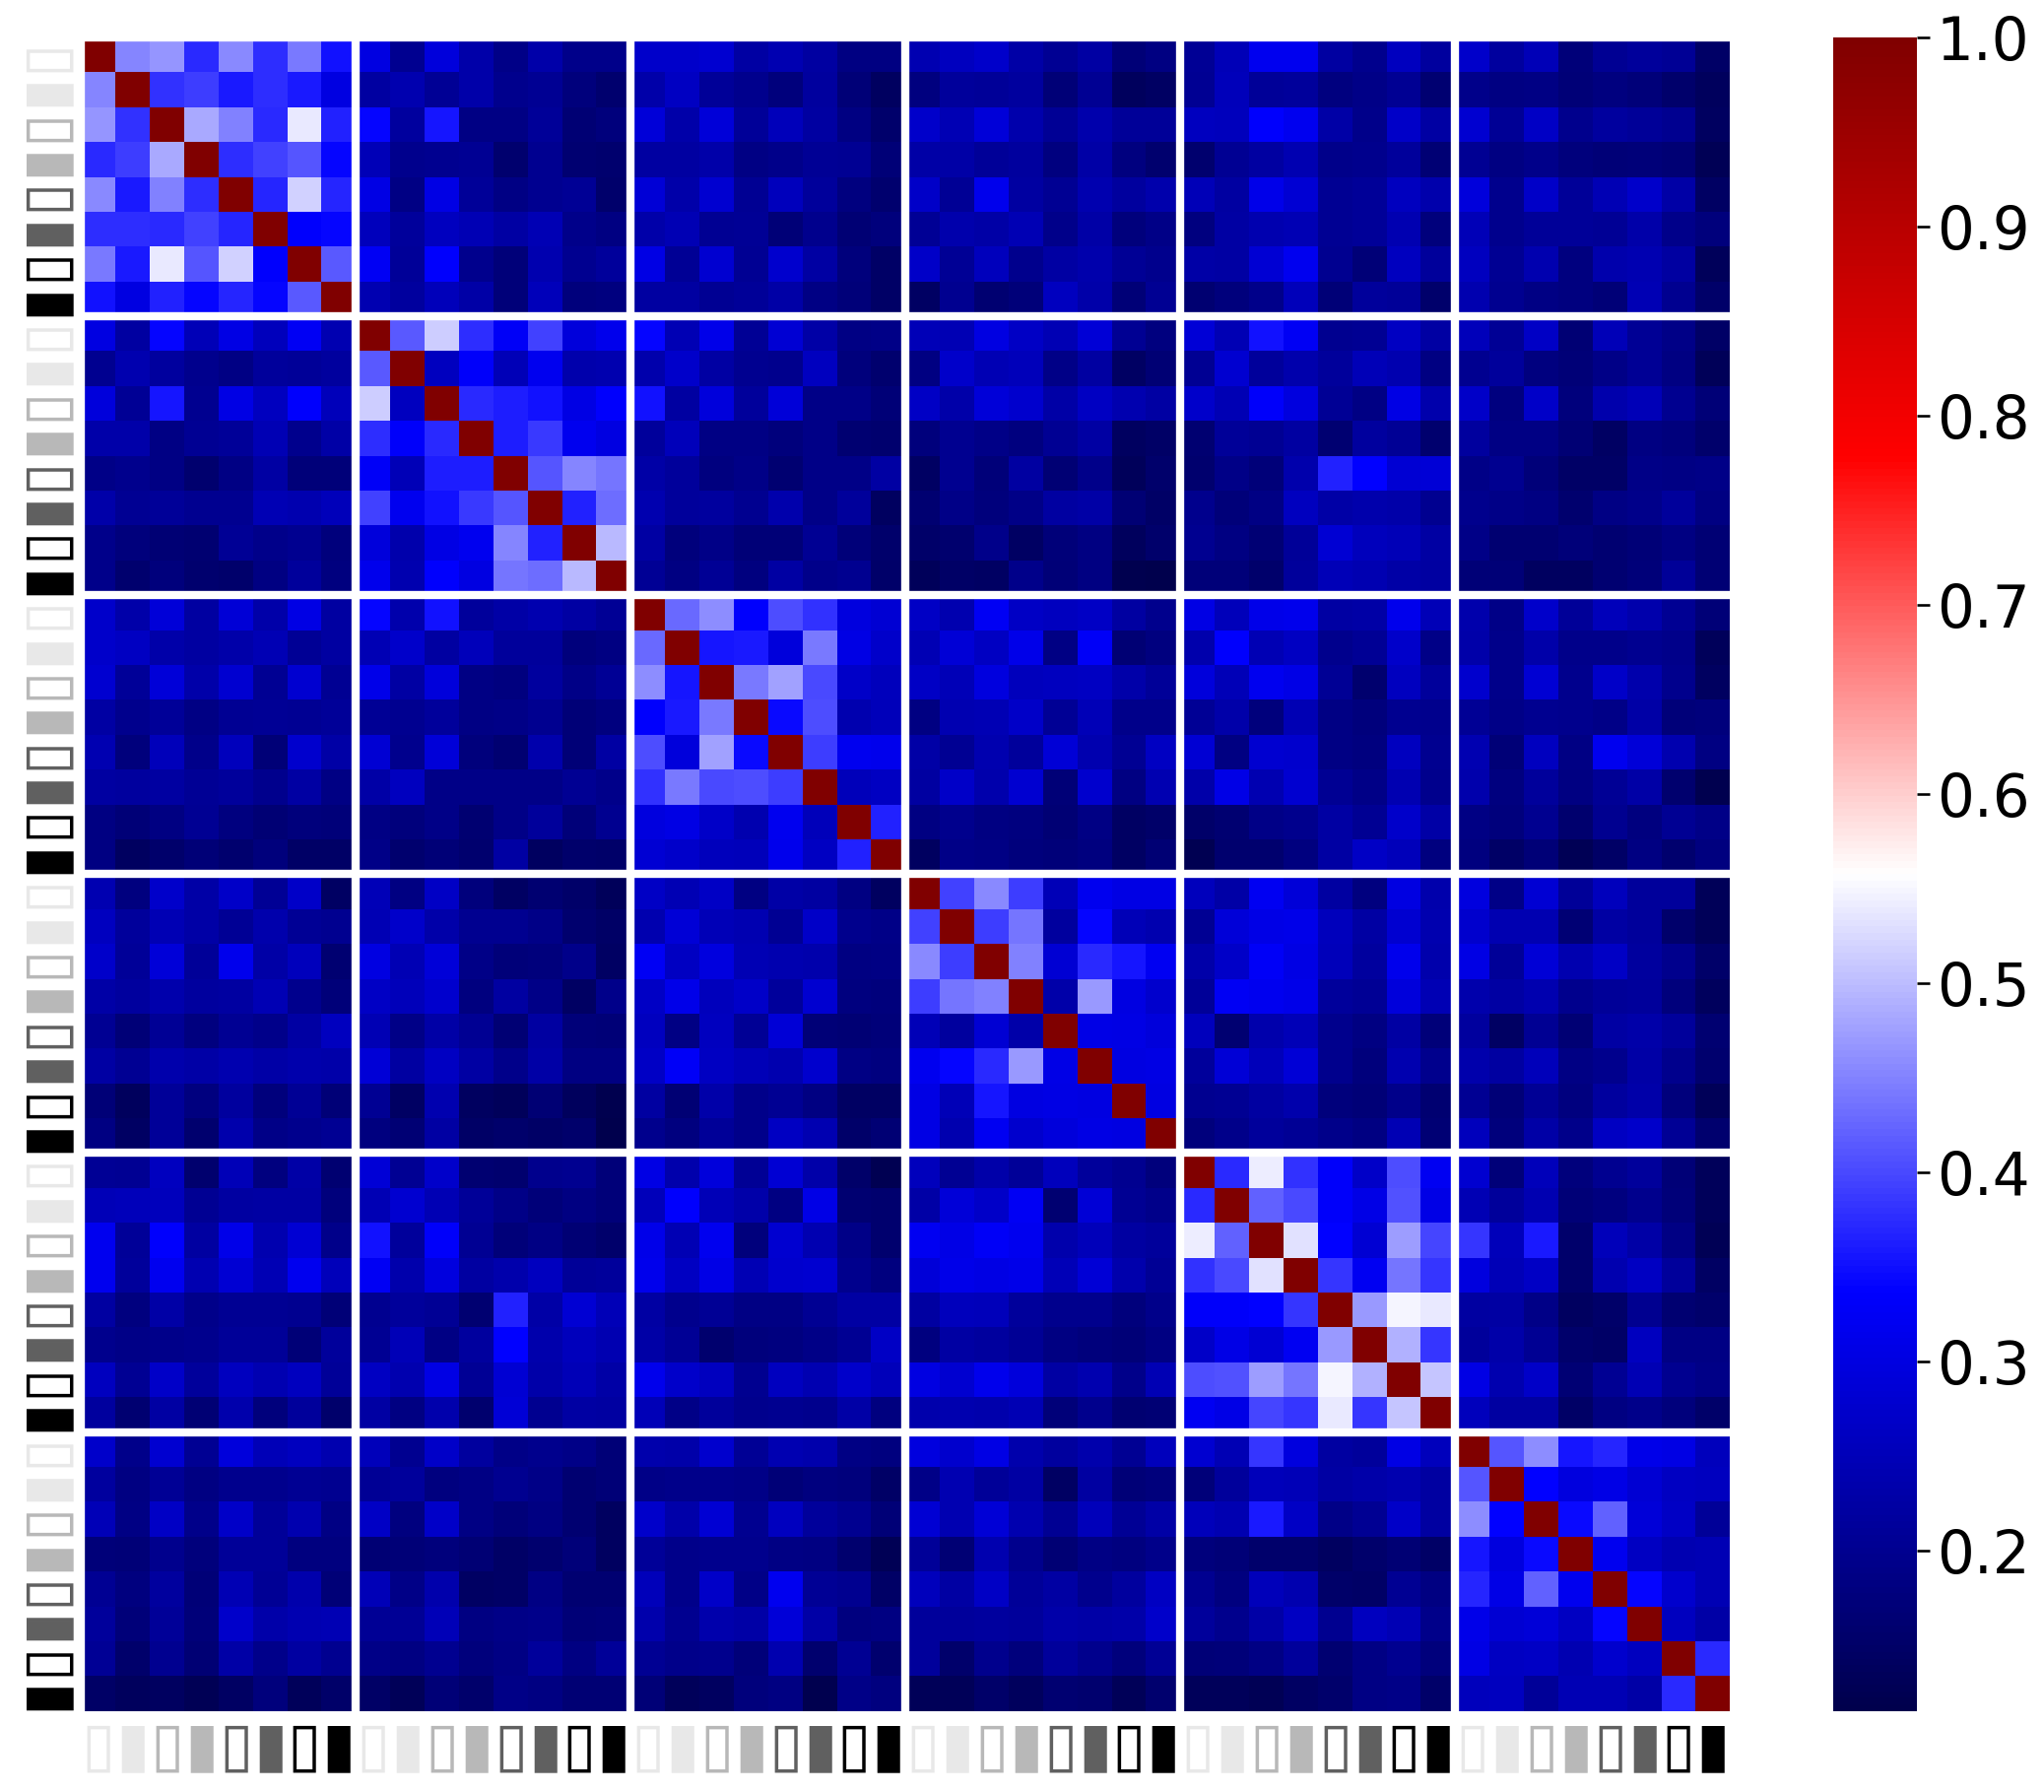

In [15]:
res = create_heatmap(mat6, 
                     labels6,  
                     num_subs=6, 
                     cmap='seismic',
                     color_list=color_list)


# TASK:  Rest  + Movie SEPARATE, 2 halves

In [18]:
# rest_mat, rest_labels = create_pairwise_similarity_matrix(six_subs, 
#                                                           ['rest'], 
#                                                           ['01','04','02','03'])

In [19]:
# movie_mat, movie_labels = create_pairwise_similarity_matrix(six_subs, 
#                                                            ['movie'], 
#                                                            ['01','04','02','03'])


In [20]:
# combined_mat = combine_rest_movie_mats(rest_mat, movie_mat, movie_labels)

# res = create_heatmap(combined_mat, 
#                      movie_labels,  
#                      num_subs=6, 
#                      color_list=color_list,
#                      markers='same',
#                      cmap='jet',
#                      labelsize=50)


# create model matrices

# task model

In [174]:
task_model = np.full([48, 48], np.nan)

for i in range(48):
    for j in range(48):
        lab_i = labels6[i]
        lab_j = labels6[j]
        if 'rest' in lab_i and 'rest' in lab_j:
            task_model[i, j] = 0 
        elif 'movie' in lab_i and 'movie' in lab_j:
            task_model[i, j] = 1  
        else:
            task_model[i, j] = .5 


# subject model

In [175]:
subj_model = np.full([48, 48], np.nan)

val_dict = {
    '01': .5,
    '02': 0.125,
    '03': 0,
    '04': 0.375,
}

for i in range(48):
    for j in range(48):
        lab_i = labels6[i]
        lab_j = labels6[j]
        
        sub_i = lab_i.split('_')[0]
        sub_j = lab_j.split('_')[0]
        
        if sub_i==sub_j:
            subj_model[i, j] = 1
        else:
            subj_model[i, j] = 0



# sedation model

In [176]:
sed_model =  np.full([48, 48], np.nan)
val_dict = {
    '01': .5,
    '02': 0.125,
    '03': 0,
    '04': 0.375,
}

for i in range(48):
    for j in range(48):
        lab_i = labels6[i]
        lab_j = labels6[j]        
        sedation_i = lab_i.split('_')[1]
        val_i = val_dict[sedation_i]
        
        sedation_j = lab_j.split('_')[1]
        val_j = val_dict[sedation_j]
        
        sed_model[i, j] = val_i + val_j




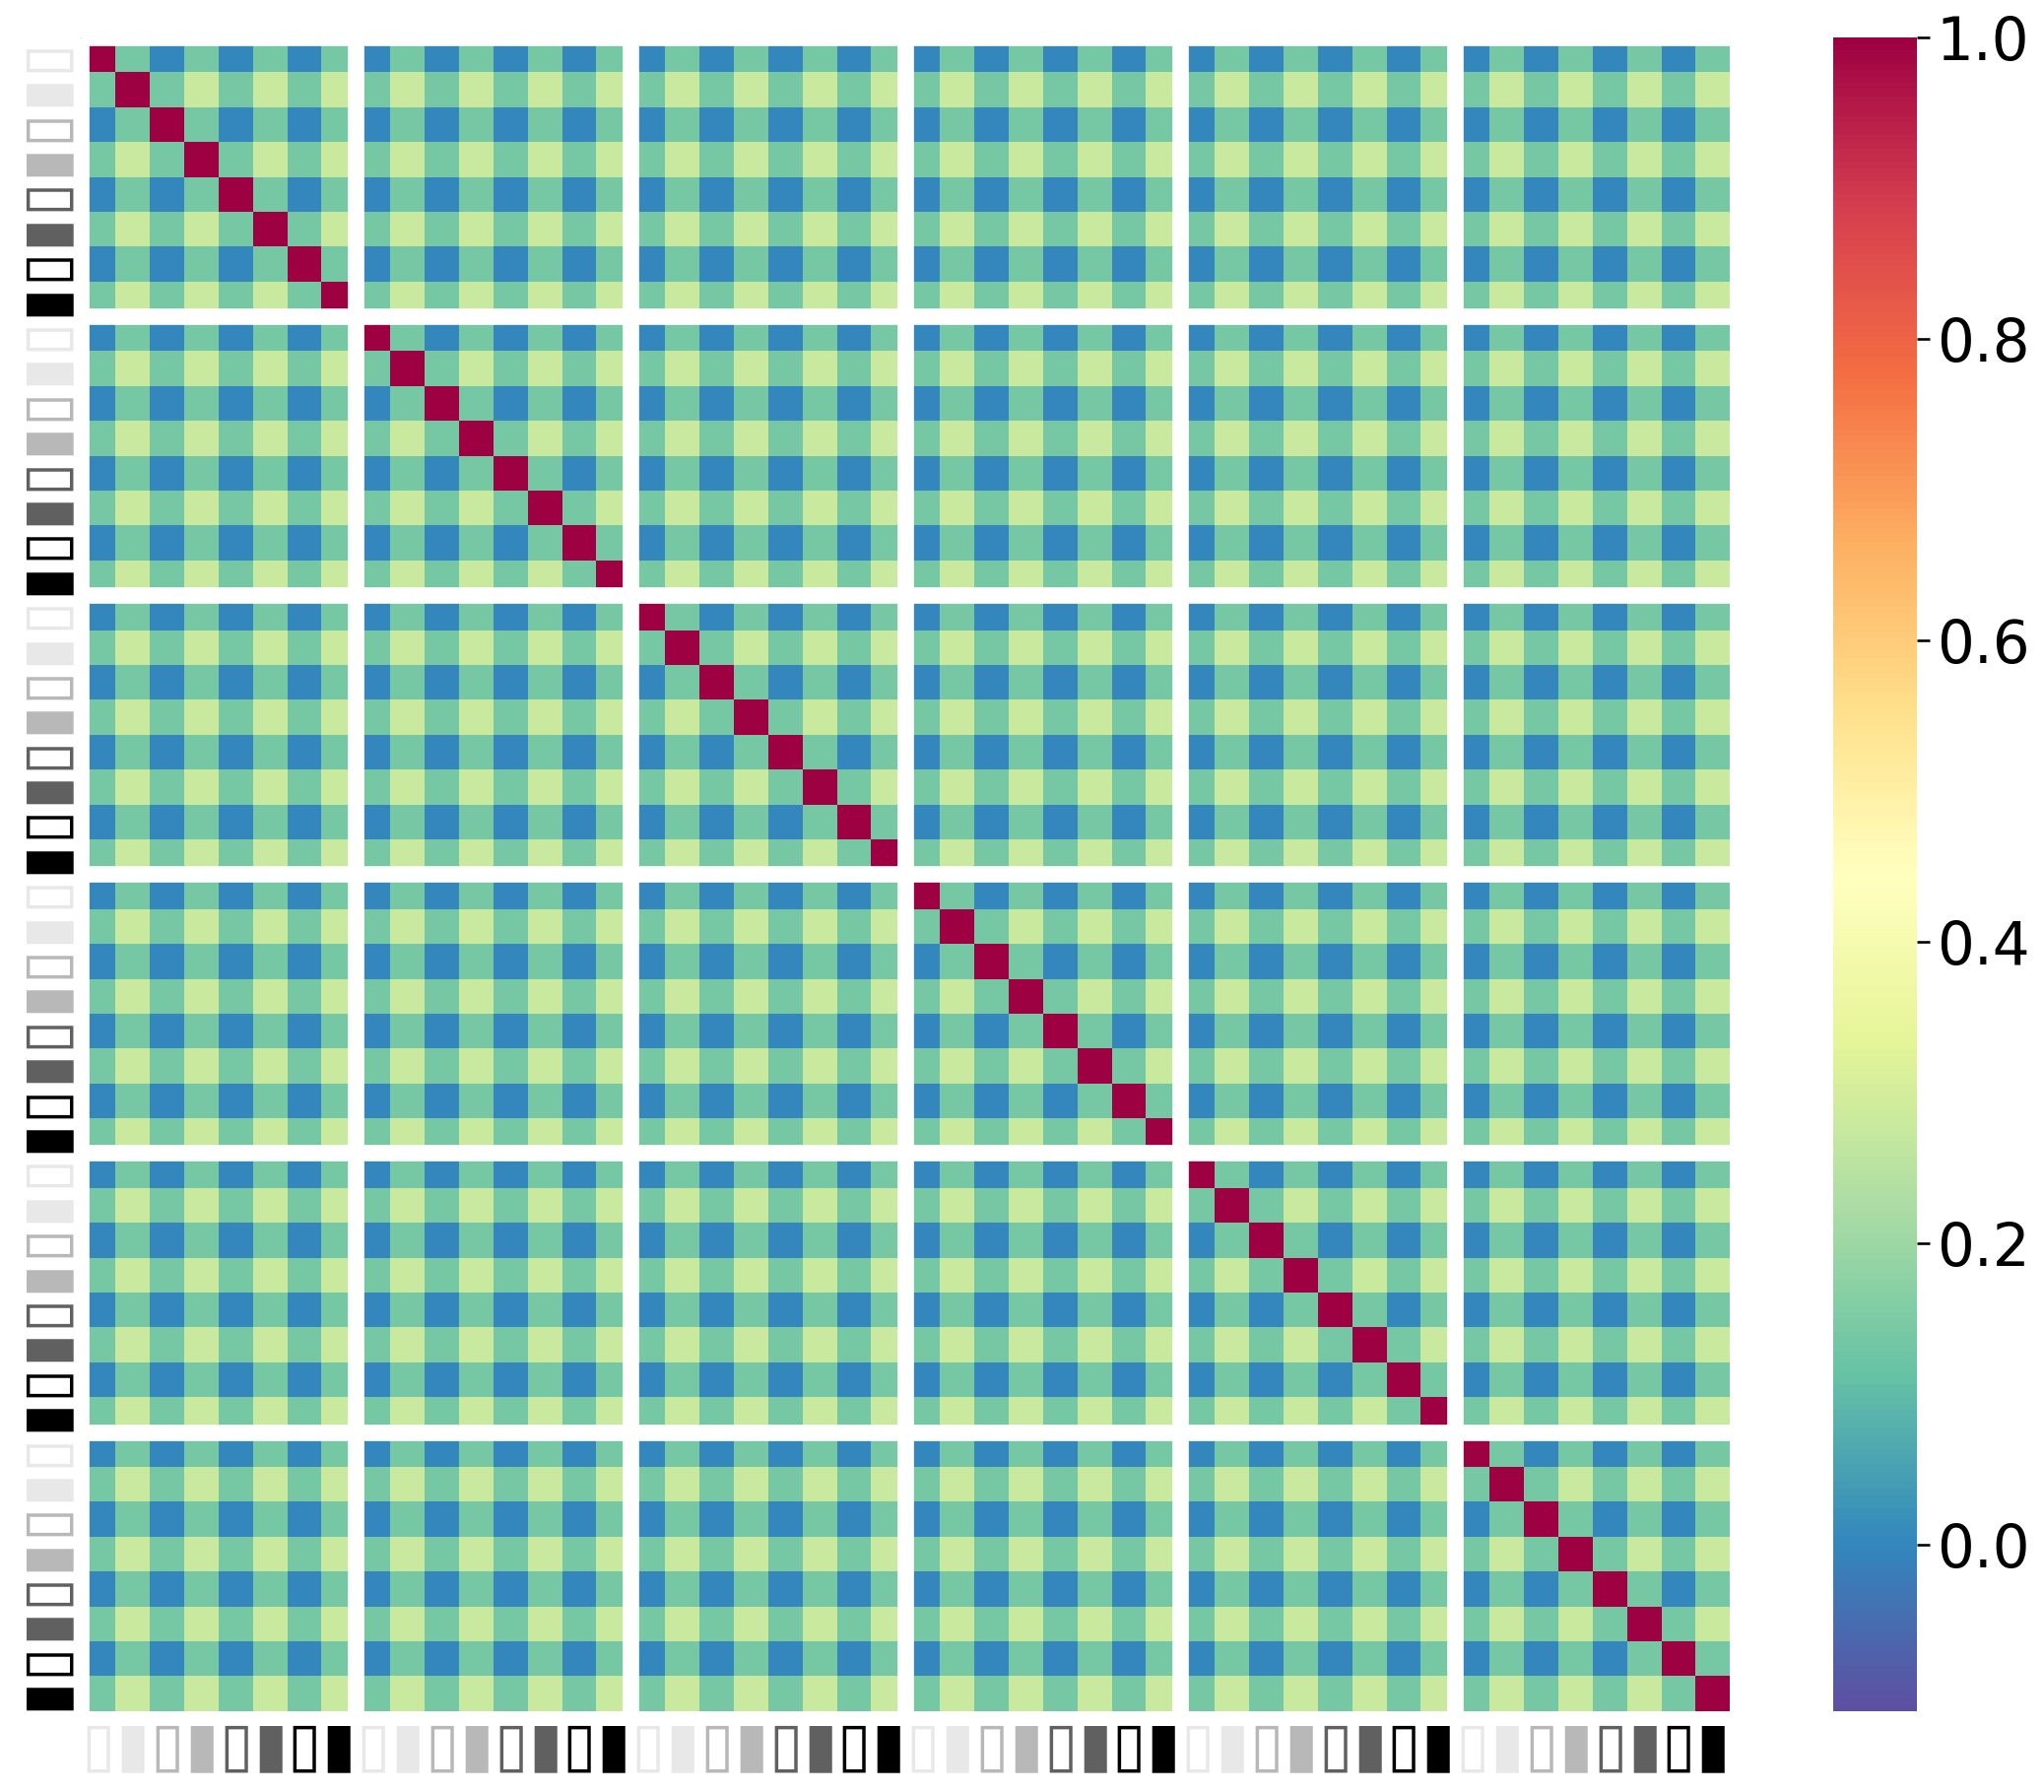

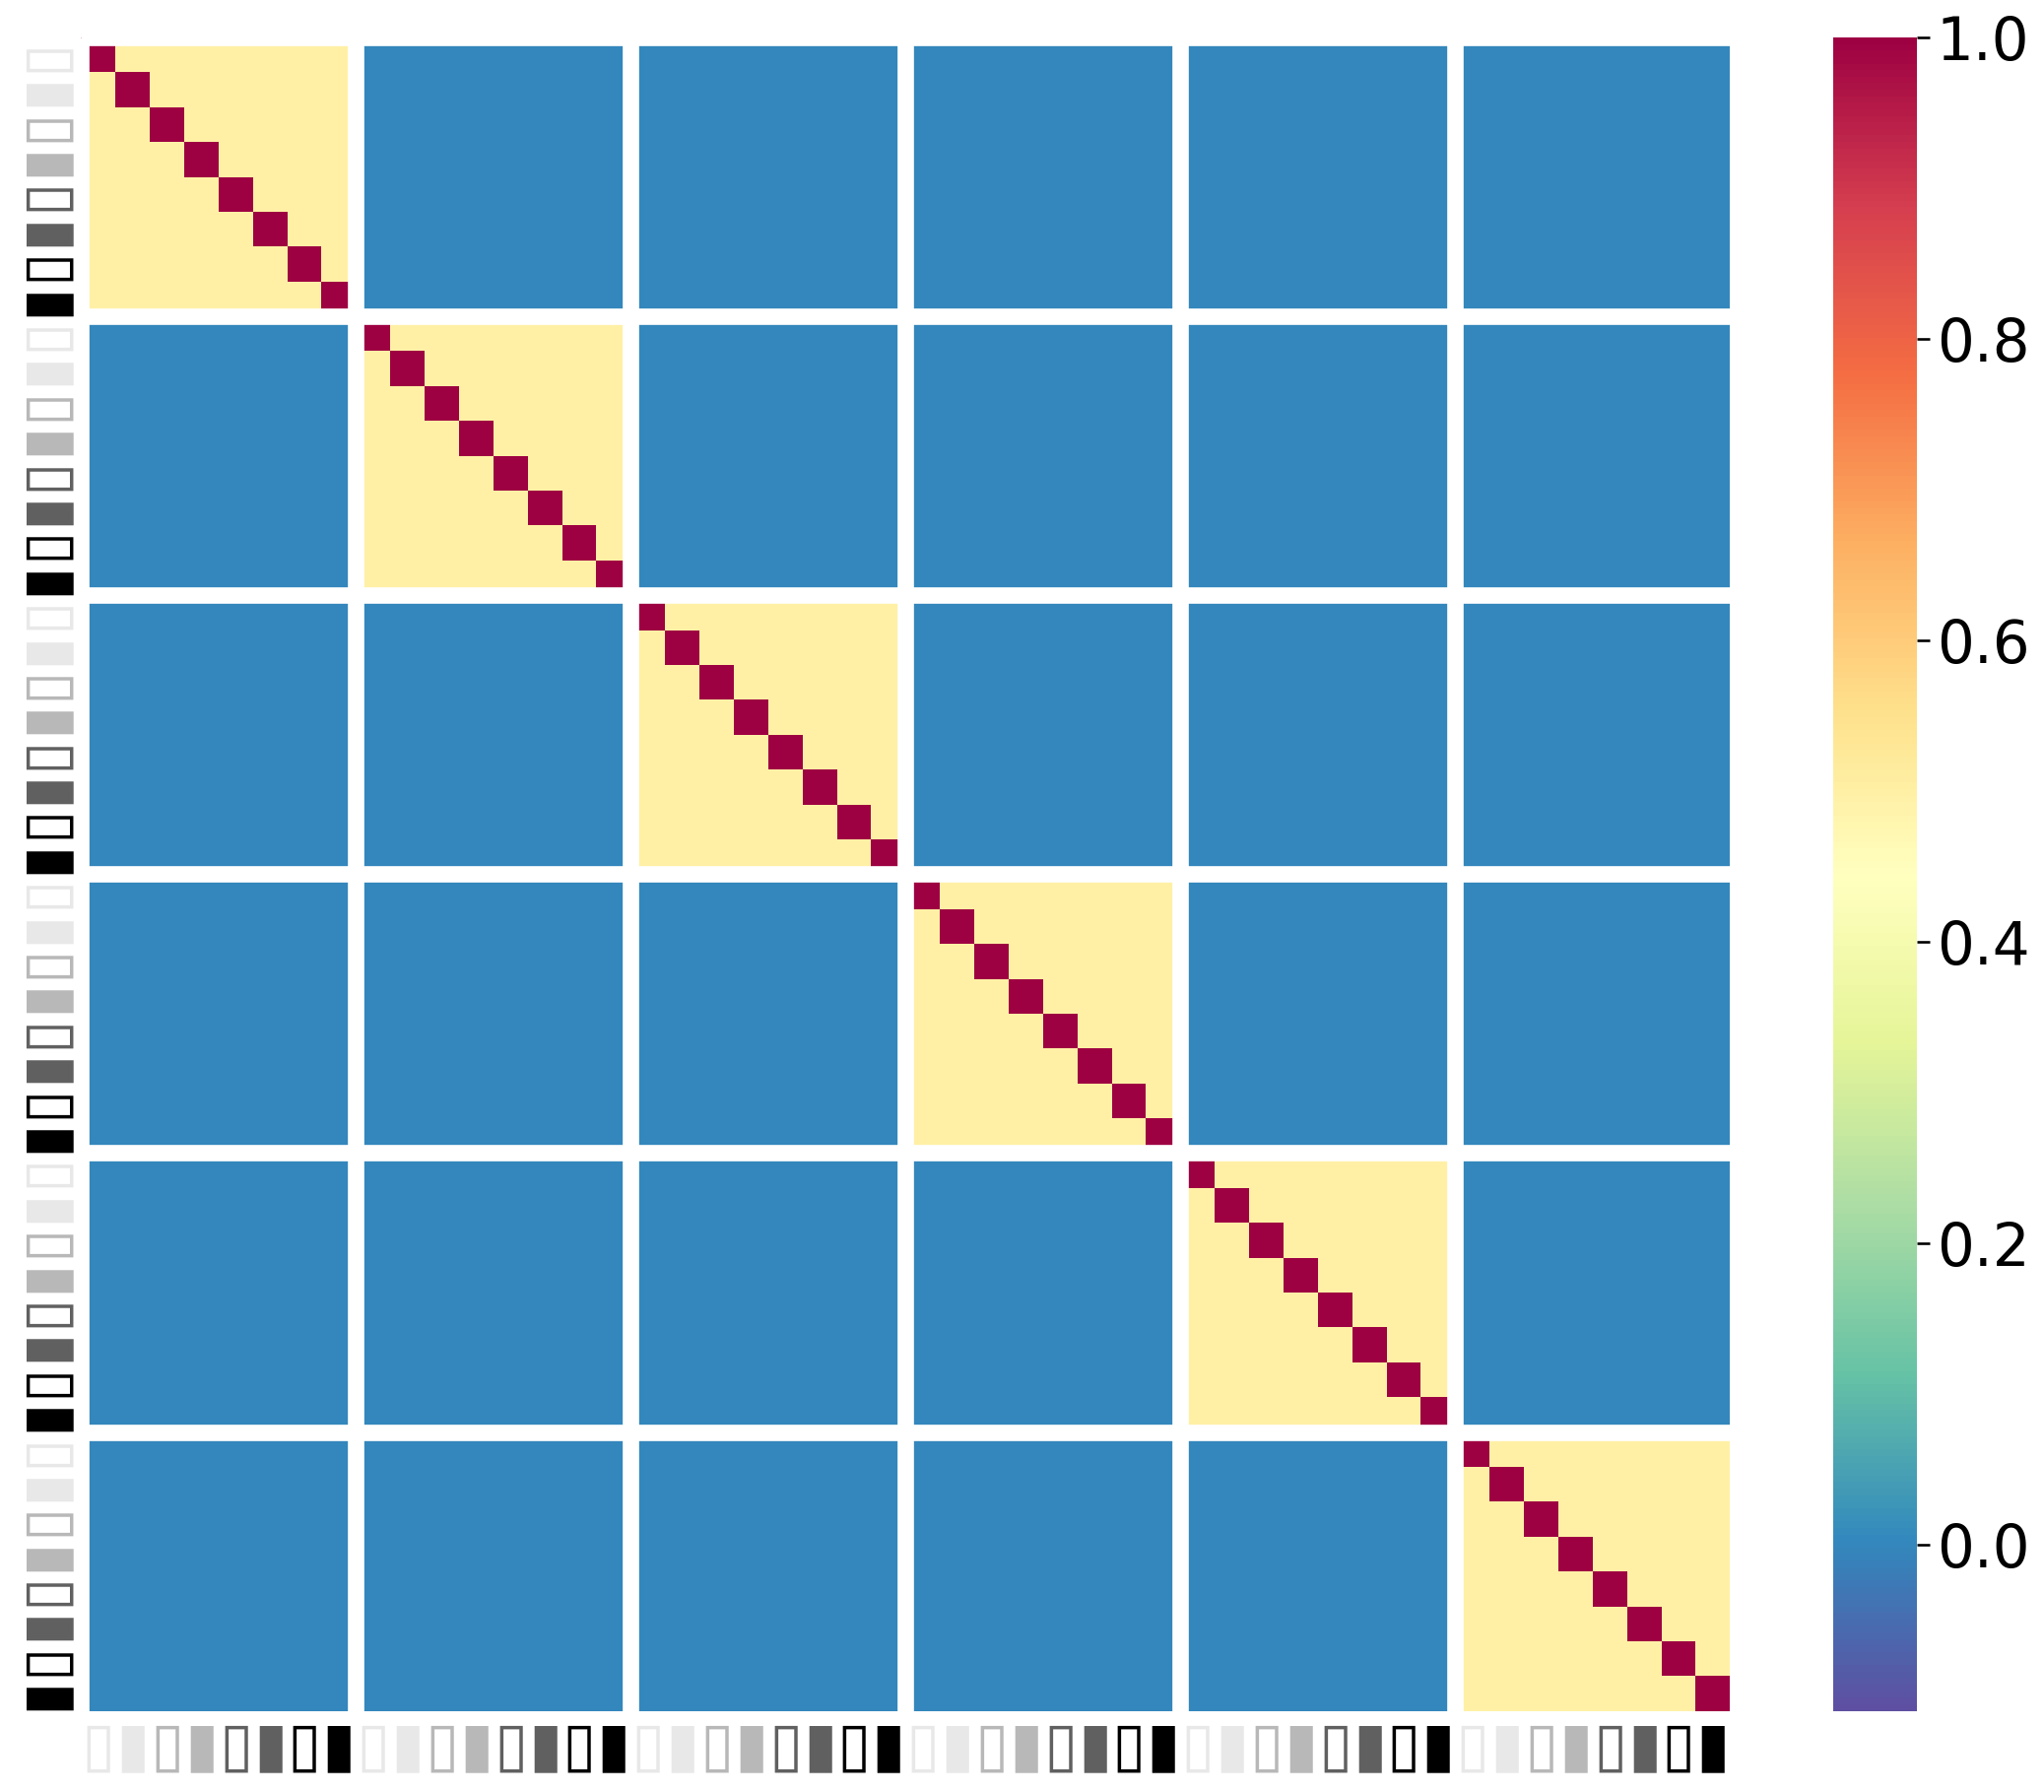

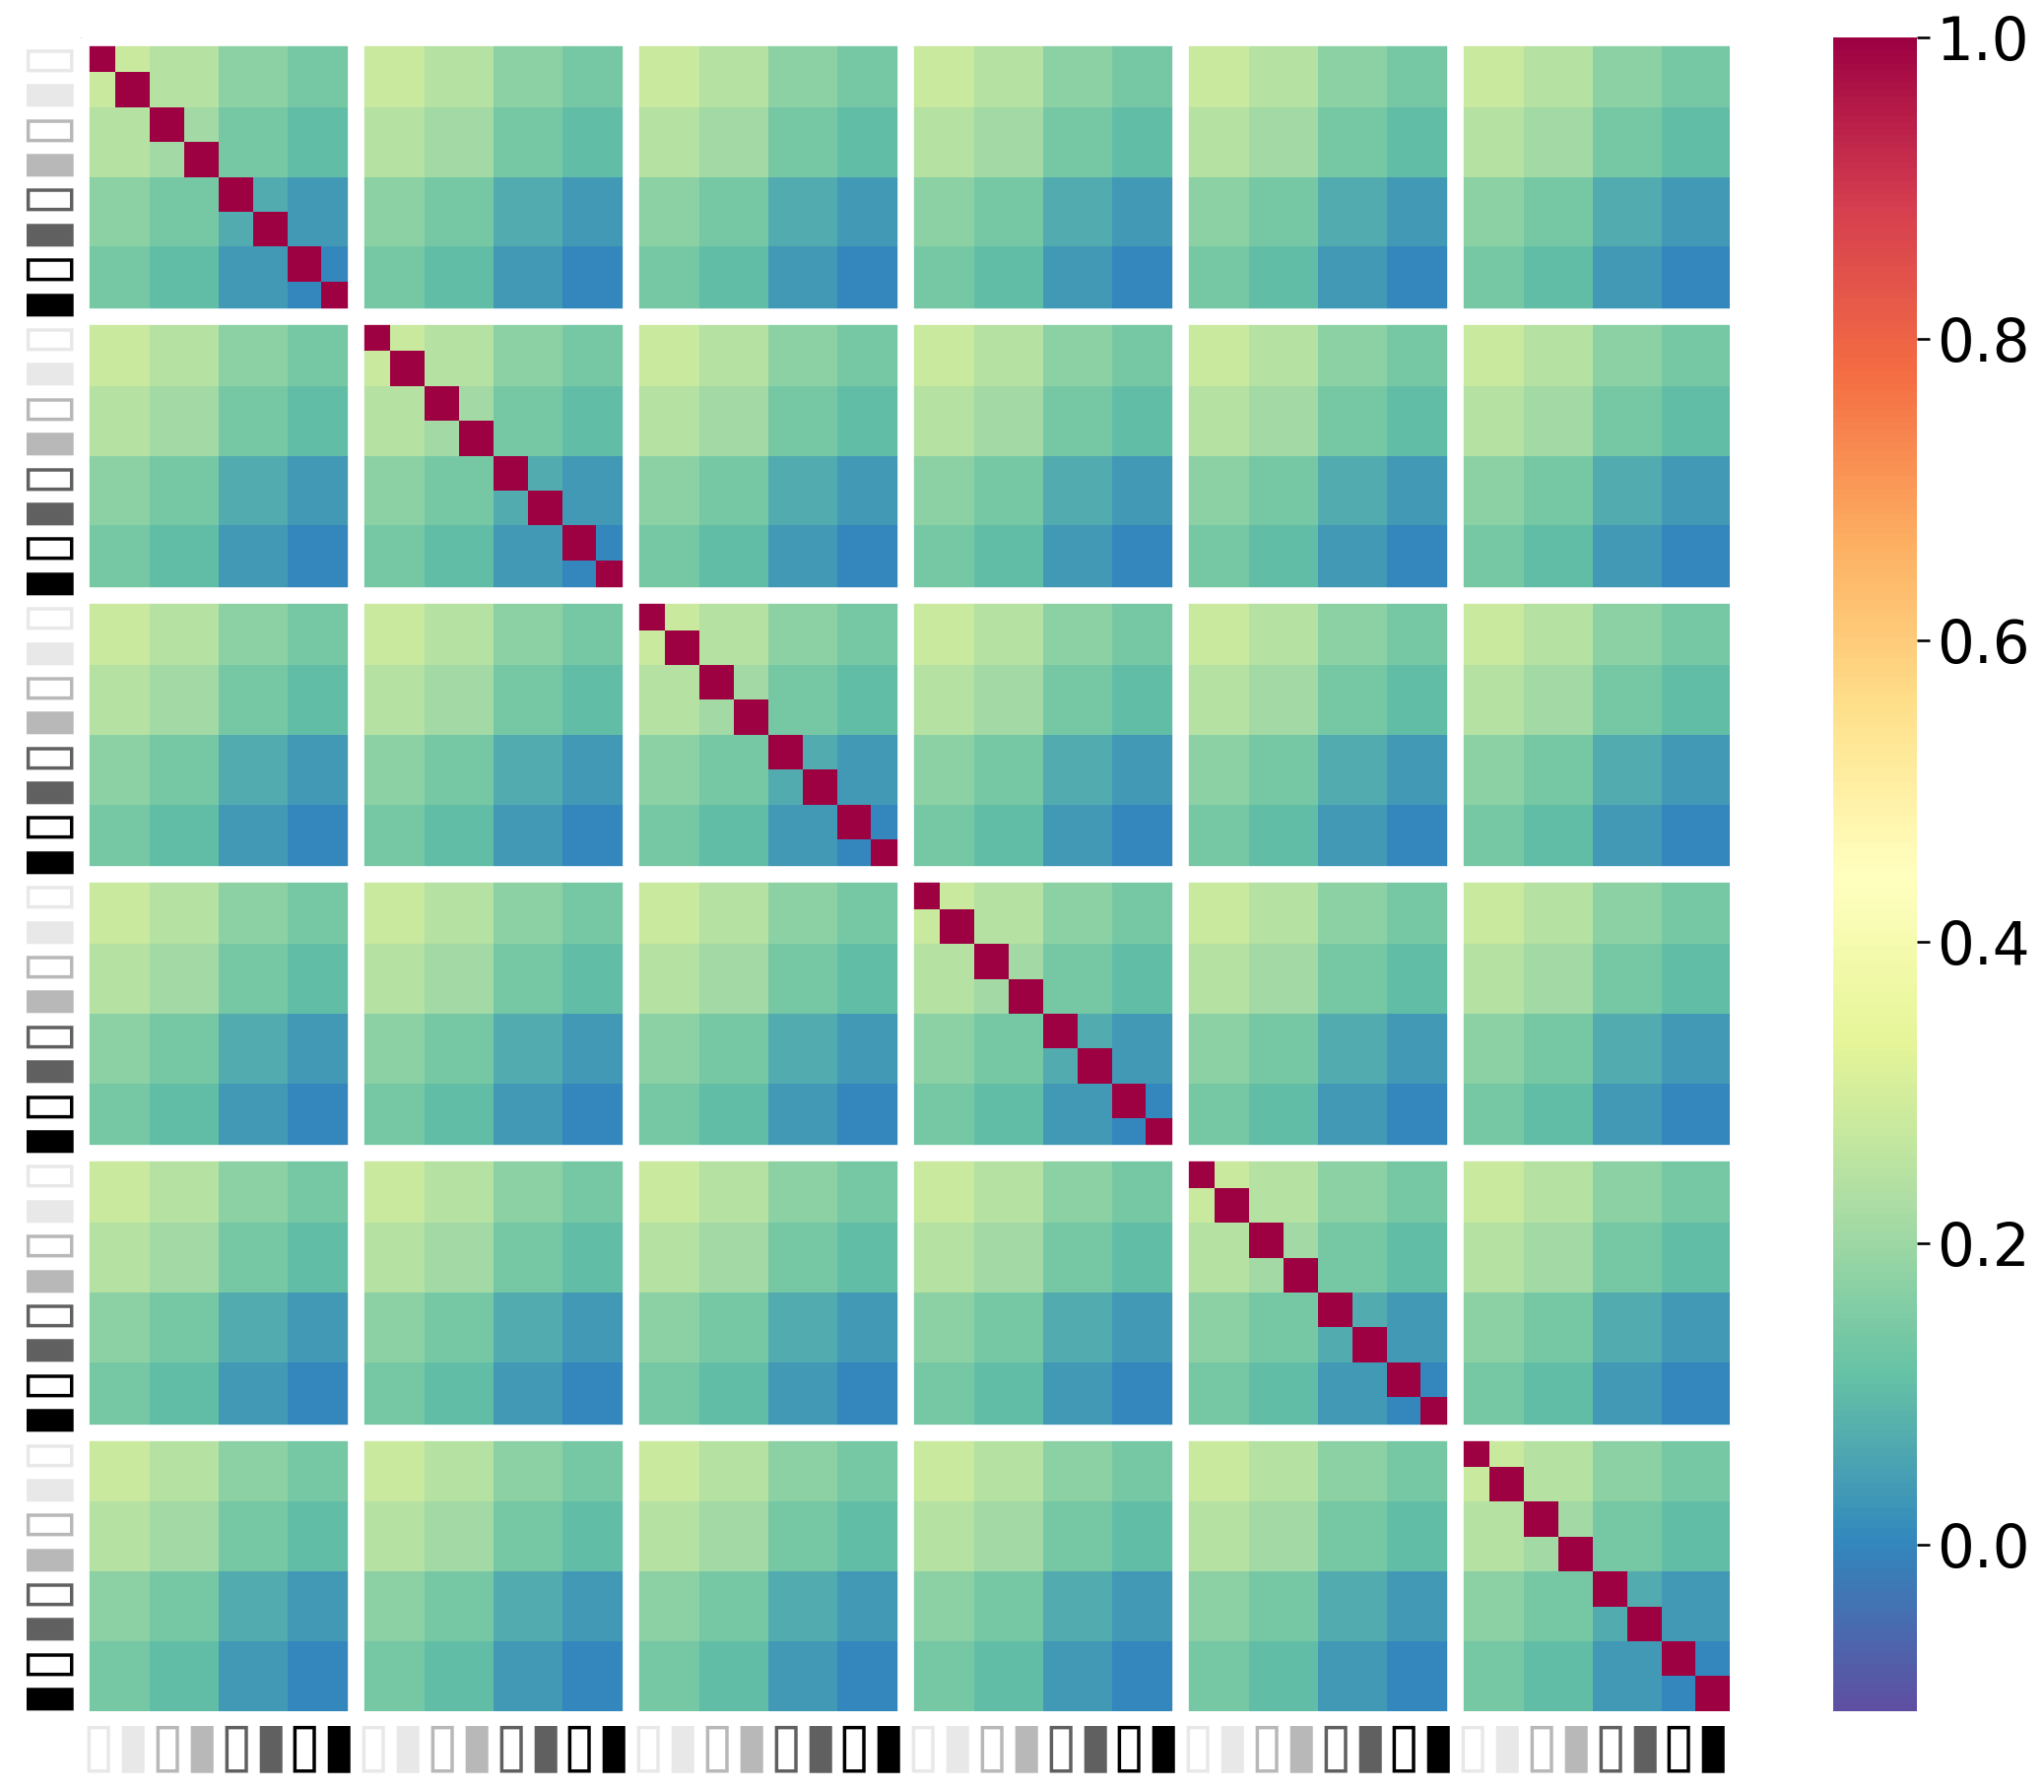

In [177]:
task_model = task_model*.56
sed_model = sed_model*.56

for model in [task_model , subj_model, sed_model]:
    model = (model*.5) 
    np.fill_diagonal(model, 1)
    res = create_heatmap(model, 
                         labels6,  
                         num_subs=6, 
                         cmap='Spectral_r',
                         vrange=[-.11, 1], 
                         separator_width=8, 
                         color_list=color_list)


# higher similarity between different runs from the same individual (mean r = XXX) 
# and relatively low similarity across individuals (mean r = XXX)

In [16]:
mat6

array([[1.        , 0.45142922, 0.46511798, ..., 0.21242876, 0.20854887,
        0.14720269],
       [0.45142922, 1.        , 0.38122462, ..., 0.1723684 , 0.15682458,
        0.13639222],
       [0.46511798, 0.38122462, 1.        , ..., 0.20978204, 0.19963677,
        0.14254058],
       ...,
       [0.21242876, 0.1723684 , 0.20978204, ..., 1.        , 0.25900222,
        0.2263891 ],
       [0.20854887, 0.15682458, 0.19963677, ..., 0.25900222, 1.        ,
        0.37385863],
       [0.14720269, 0.13639222, 0.14254058, ..., 0.2263891 , 0.37385863,
        1.        ]])

In [18]:
all_within = []
# grab within-vals
all_btwn = []

for i in range(48):
    for j in range(48):
        lab_i = labels6[i]
        lab_j = labels6[j]
        
        sub_i = lab_i.split('_')[0]
        sub_j = lab_j.split('_')[0]
        
        if sub_i==sub_j:
            all_within.append(mat6[i,j])
        else:
            all_btwn.append(mat6[i,j])
            


In [19]:
np.mean(all_within)

0.4358881057467907

In [20]:
np.mean(all_btwn)
# grab between-vals

0.2136681854918064